# EDA of transaction and customer data

## Overall

In [2]:
from src.utils.bq import BQ
from google.cloud import bigquery

bq = BQ()

/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [3]:
CUSTOMER_QUERY = """

SELECT customer_id 
FROM `mpb-data-science-dev-ab-602d.dsci_daw.STV` 
GROUP BY customer_id 
ORDER BY count(*) DESC 
LIMIT 1000 OFFSET 10000

"""

customers = bq.to_dataframe(CUSTOMER_QUERY)["customer_id"].tolist()

In [4]:
TRANSACTION_QUERY = """

SELECT *
FROM `mpb-data-science-dev-ab-602d.dsci_daw.STV` 
WHERE customer_id IN UNNEST(@customer_ids)
ORDER BY customer_id, transaction_completed_datetime

"""


job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("customer_ids", "INT64", customers)
    ]
)
transactions = bq.to_dataframe(TRANSACTION_QUERY, job_config=job_config)

In [5]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51034 entries, 0 to 51033
Data columns (total 88 columns):
 #   Column                                       Non-Null Count  Dtype              
---  ------                                       --------------  -----              
 0   transaction_id                               51034 non-null  object             
 1   customer_id                                  51034 non-null  Int64              
 2   transaction_type                             51034 non-null  object             
 3   quoted_sell_items                            42548 non-null  Int64              
 4   secured_sell_items                           42548 non-null  Int64              
 5   sold_sell_items                              42548 non-null  Int64              
 6   total_buy_items                              7887 non-null   Int64              
 7   delivery_charge_market                       7887 non-null   float64            
 8   delivery_charge_market_inc

In [6]:
for column in transactions.columns:
    print(f"- {column}: {transactions[column].unique()[:5]}")

- transaction_id: ['7f75d2e2-2970-4c2d-b84e-dbd0182b161f'
 '973d3383-efda-434e-8157-70c31467dbf4'
 '98533f5c-c4e0-4800-a5c2-dc57a7acef01'
 'c3f259cf-ea27-451b-9cf6-2231f6beb205'
 'c5d492e1-7381-40e2-ac85-cc0fc031ec4d']
- customer_id: <IntegerArray>
[812991, 814314, 820041, 820494, 827450]
Length: 5, dtype: Int64
- transaction_type: ['SELLING' 'RETURN' 'TRADING' 'BUYING' 'PART REFUND']
- quoted_sell_items: <IntegerArray>
[<NA>, 2, 1, 5, 4]
Length: 5, dtype: Int64
- secured_sell_items: <IntegerArray>
[<NA>, 0, 11, 2, 1]
Length: 5, dtype: Int64
- sold_sell_items: <IntegerArray>
[<NA>, 0, 2, 1, 3]
Length: 5, dtype: Int64
- total_buy_items: <IntegerArray>
[<NA>, 2, 5, 1, 3]
Length: 5, dtype: Int64
- delivery_charge_market: [   nan   0.    -8.95  -5.95 -16.95]
- delivery_charge_market_inc_vat_salestax: [   nan   0.    -8.95  -5.95 -16.95]
- delivery_charge_market_exc_vat_salestax: [   nan   0.    -7.45  -4.95 -14.12]
- buy_value_market: [   nan -1848.  -345. -3999. -5749.]
- buy_value_market

array([[<Axes: title={'center': 'customer_id'}>,
        <Axes: title={'center': 'quoted_sell_items'}>,
        <Axes: title={'center': 'secured_sell_items'}>,
        <Axes: title={'center': 'sold_sell_items'}>,
        <Axes: title={'center': 'total_buy_items'}>,
        <Axes: title={'center': 'delivery_charge_market'}>,
        <Axes: title={'center': 'delivery_charge_market_inc_vat_salestax'}>,
        <Axes: title={'center': 'delivery_charge_market_exc_vat_salestax'}>],
       [<Axes: title={'center': 'buy_value_market'}>,
        <Axes: title={'center': 'buy_value_market_inc_vat_salestax'}>,
        <Axes: title={'center': 'buy_value_market_exc_vat_salestax'}>,
        <Axes: title={'center': 'buy_value_operational'}>,
        <Axes: title={'center': 'gmv'}>,
        <Axes: title={'center': 'total_quoted_sell_value'}>,
        <Axes: title={'center': 'total_secure_sell_value'}>,
        <Axes: title={'center': 'total_sold_sell_value'}>],
       [<Axes: title={'center': 'total_so

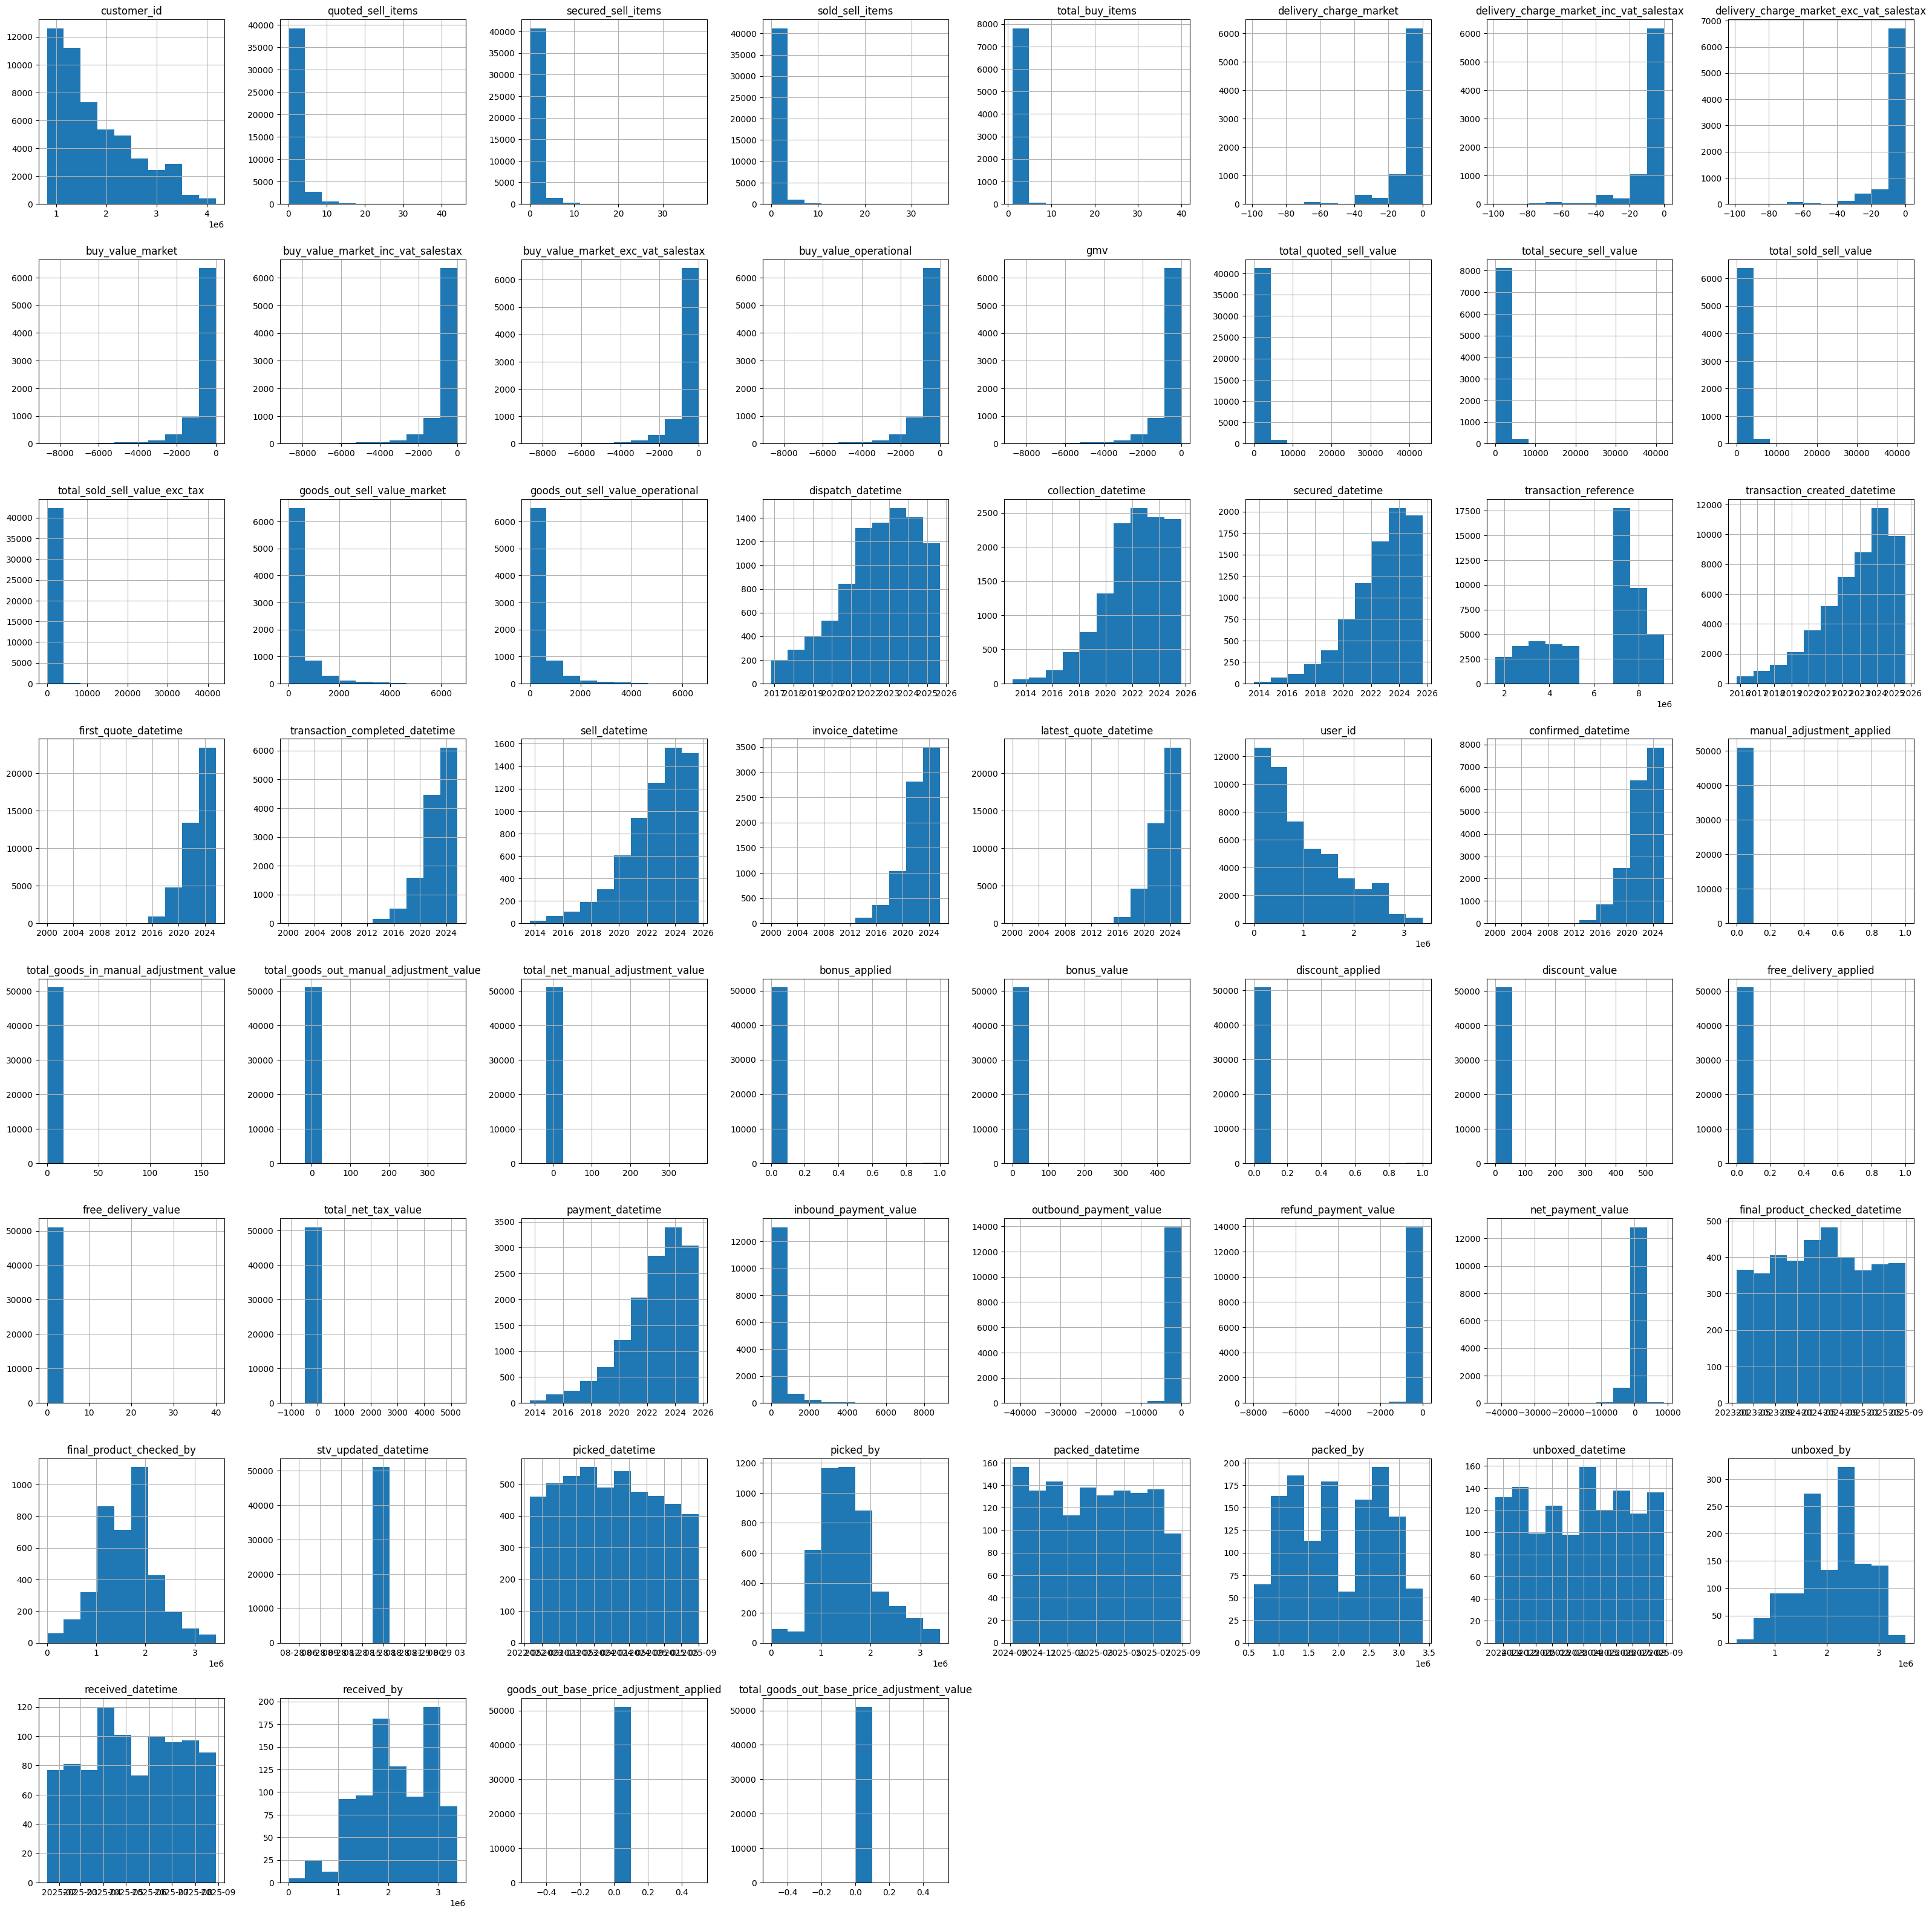

In [7]:
transactions.hist(figsize=(40, 40))

## Agg by customer

In [8]:
TRANSACTION_QUERY = """

SELECT 
customer_id, 
COUNT(*) AS total_transactions
FROM `mpb-data-science-dev-ab-602d.dsci_daw.STV` 
GROUP BY customer_id
ORDER BY total_transactions

"""


job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("customer_ids", "INT64", customers)
    ]
)
transactions = bq.to_dataframe(TRANSACTION_QUERY, job_config=job_config)

In [9]:
transactions["total_transactions"].value_counts()

total_transactions
1       1609669
2        463796
3        221721
4        134054
5         87699
         ...   
482           1
483           1
487           1
488           1
5904          1
Name: count, Length: 548, dtype: Int64

<Axes: xlabel='total_transactions'>

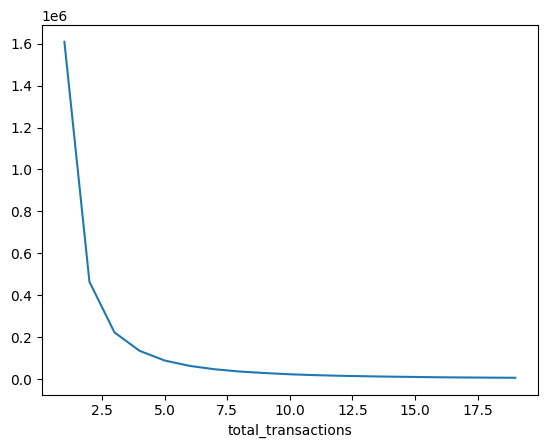

In [10]:
_transactions = transactions[transactions["total_transactions"] < 20]
_transactions["total_transactions"].value_counts().plot()

In [11]:
import numpy as np
transactions["total_transactions"].quantile(np.arange(0, 1.1, 0.1))

0.0       1.0
0.1       1.0
0.2       1.0
0.3       1.0
0.4       1.0
0.5       1.0
0.6       2.0
0.7       2.0
0.8       3.0
0.9       6.0
1.0    5904.0
Name: total_transactions, dtype: Float64

In [12]:
TRANSACTION_QUERY = """

WITH transaction_data AS (
  SELECT
    customer_id,
    COUNT(*) AS total_transactions,
    -- use seconds for precision, then convert to days
    TIMESTAMP_DIFF(MAX(transaction_completed_datetime),
                   MIN(transaction_completed_datetime),
                   SECOND) AS lifetime_seconds
  FROM `mpb-data-science-dev-ab-602d.dsci_daw.STV`
  WHERE transaction_completed_datetime IS NOT NULL
  GROUP BY customer_id
)

SELECT
  customer_id,
  -- average gap in days between transactions based on first & last
  SAFE_DIVIDE(lifetime_seconds, 86400 * (total_transactions - 1)) AS avg_frequency_days
FROM transaction_data
WHERE total_transactions > 1
ORDER BY total_transactions, customer_id

"""

job_config = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ArrayQueryParameter("customer_ids", "INT64", customers)
    ]
)
transactions = bq.to_dataframe(TRANSACTION_QUERY, job_config=job_config)

In [13]:
transactions["avg_frequency_days"].quantile(np.arange(0, 1.1, 0.1))

0.0       0.000000
0.1       8.916354
0.2      31.122697
0.3      69.956065
0.4     115.817303
0.5     169.006833
0.6     235.873677
0.7     327.926900
0.8     462.800000
0.9     742.226169
1.0    5066.000000
Name: avg_frequency_days, dtype: float64

## A look at Cohorts

In [14]:
from src.utils.bq import BQ
from google.cloud import bigquery

# Initialize BigQuery connection
bq = BQ()

# Get transaction data - FIXED QUERY
TRANSACTION_QUERY = """
WITH base AS (
  SELECT
    customer_id,
    case when market = 'us' then 'US'
    when market = 'uk' then 'UK'
    else 'EU' end as market,
    transaction_completed_datetime
  FROM `mpb-data-science-dev-ab-602d.dsci_daw.STV`
  WHERE transaction_state = 'COMPLETED'
    AND transaction_completed_datetime IS NOT NULL
),
first_two AS (
  SELECT
    customer_id,
    market,
    ARRAY_AGG(transaction_completed_datetime ORDER BY transaction_completed_datetime) AS txns
  FROM base
  GROUP BY customer_id, market
)
SELECT
  customer_id,
  market,
  DATE(txns[OFFSET(0)]) AS first_txn_date,
  CASE 
    WHEN ARRAY_LENGTH(txns) >= 2 THEN
      DATE_DIFF(DATE(txns[OFFSET(1)]), DATE(txns[OFFSET(0)]), DAY)
    ELSE 0
  END AS days_between_first_and_second
FROM first_two;
"""

job_config = bigquery.QueryJobConfig()
dtypes = {
    'customer_id': 'int32',
    'market': 'string',
    'first_txn_date': 'datetime64[ns]',
    'days_between_first_and_second': 'int32'
}

df = bq.to_dataframe(TRANSACTION_QUERY, job_config=job_config, dtypes=dtypes)

/Users/anthonybeech/python/dsci/ltv/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [15]:
df.describe()

,customer_id,first_txn_date,days_between_first_and_second
count,3.654740e+05,365474,365474.000000
mean,2.192524e+06,2022-04-11 16:40:09.600682496,108.168931
min,8.120850e+05,2012-09-27 00:00:00,0.000000
25%,1.340565e+06,2020-12-03 00:00:00,0.000000
50%,2.103068e+06,2022-12-08 00:00:00,0.000000
75%,2.934677e+06,2024-05-07 00:00:00,16.000000
max,4.339079e+06,2025-08-28 00:00:00,4510.000000
std,9.567005e+05,NaN,320.008070


In [16]:
import pandas as pd
import numpy as np

df = df.copy()
df['first_txn_date'] = pd.to_datetime(df['first_txn_date'])
df['cohort_year'] = df['first_txn_date'].dt.year
df['has_second'] = df['days_between_first_and_second'] > 0

# thresholds (days) for time-to-2nd within X days
THRESHOLDS = [7, 14, 30, 60, 90, 180]

def agg_block(g):
    n = len(g)
    n_second = g['has_second'].sum()
    share_second = n_second / n if n else np.nan

    # conditional stats (only customers with a second txn)
    d = g.loc[g['has_second'], 'days_between_first_and_second']
    mean_c = d.mean() if len(d) else np.nan
    med_c  = d.median() if len(d) else np.nan
    q25_c  = d.quantile(0.25) if len(d) else np.nan
    q75_c  = d.quantile(0.75) if len(d) else np.nan
    iqr_c  = q75_c - q25_c if len(d) else np.nan

    # optional: unconditional stats (including zeros)
    du = g['days_between_first_and_second']
    mean_u = du.mean() if len(du) else np.nan
    med_u  = du.median() if len(du) else np.nan

    # % second within thresholds (denominator = all customers)
    pct_within = {}
    if n:
        for t in THRESHOLDS:
            pct_within[f'pct_second_within_{t}d'] = ( (du > 0) & (du <= t) ).mean()
    else:
        for t in THRESHOLDS:
            pct_within[f'pct_second_within_{t}d'] = np.nan

    return pd.Series({
        'n_customers': n,
        'n_second_txn': n_second,
        'share_second_txn': share_second,
        'days_to_2nd_mean_cond': mean_c,
        'days_to_2nd_median_cond': med_c,
        'days_to_2nd_q25_cond': q25_c,
        'days_to_2nd_q75_cond': q75_c,
        'days_to_2nd_iqr_cond': iqr_c,
        'days_to_2nd_mean_uncond': mean_u,
        'days_to_2nd_median_uncond': med_u,
        **pct_within
    })

stats = (
    df
    .groupby(['market', 'cohort_year'], as_index=False)
    .apply(agg_block)
    .reset_index(drop=True)
    .sort_values(['market', 'cohort_year'])
)

# If you want a neat column order:
ordered_cols = (
    ['market','cohort_year','n_customers','n_second_txn','share_second_txn',
     'days_to_2nd_mean_cond','days_to_2nd_median_cond','days_to_2nd_q25_cond',
     'days_to_2nd_q75_cond','days_to_2nd_iqr_cond','days_to_2nd_mean_uncond',
     'days_to_2nd_median_uncond']
    + [f'pct_second_within_{t}d' for t in THRESHOLDS]
)
stats = stats[ordered_cols].sort_values(['market', 'cohort_year'])


/var/folders/6q/6rsf1x3d1k7fzrsyrjyf8wnc0000gp/T/ipykernel_7859/1059035066.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_block)


In [17]:
stats[stats['market'] == 'UK']

,market,cohort_year,n_customers,n_second_txn,share_second_txn,days_to_2nd_mean_cond,days_to_2nd_median_cond,days_to_2nd_q25_cond,days_to_2nd_q75_cond,days_to_2nd_iqr_cond,days_to_2nd_mean_uncond,days_to_2nd_median_uncond,pct_second_within_7d,pct_second_within_14d,pct_second_within_30d,pct_second_within_60d,pct_second_within_90d,pct_second_within_180d
9,UK,2012,916.0,403.0,0.439956,856.243176,414.0,144.50,1104.50,960.00,376.709607,0.0,0.006550,0.014192,0.032751,0.054585,0.074236,0.123362
10,UK,2013,3493.0,1514.0,0.433438,890.128137,473.0,146.00,1207.75,1061.75,385.815631,0.0,0.007157,0.020326,0.040653,0.061552,0.083309,0.123676
11,UK,2014,4144.0,1875.0,0.452461,853.176533,460.0,138.00,1197.00,1059.00,386.029440,0.0,0.008687,0.024131,0.044884,0.069981,0.088320,0.134170
12,UK,2015,4622.0,1964.0,0.424924,833.518330,489.5,146.00,1232.25,1086.25,354.182172,0.0,0.007572,0.019256,0.044569,0.064474,0.080917,0.121160
13,UK,2016,5698.0,2499.0,0.438575,756.327331,436.0,114.50,1177.00,1062.50,331.706213,0.0,0.013163,0.026852,0.049140,0.075290,0.097227,0.141278
14,UK,2017,7971.0,3285.0,0.412119,689.895282,426.0,105.00,1043.00,938.00,284.318906,0.0,0.017187,0.032242,0.054698,0.077657,0.095722,0.135617
15,UK,2018,9662.0,3747.0,0.387808,617.456098,364.0,94.00,984.00,890.00,239.454357,0.0,0.018630,0.032291,0.056407,0.078969,0.095218,0.138170
16,UK,2019,10954.0,4336.0,0.395837,541.511762,312.5,62.00,877.25,815.25,214.350466,0.0,0.026474,0.044733,0.069929,0.097499,0.117948,0.155925
17,UK,2020,13015.0,5132.0,0.394314,467.607560,292.5,68.00,721.25,653.25,184.384326,0.0,0.024587,0.042028,0.067845,0.093046,0.114176,0.156973
18,UK,2021,16635.0,5988.0,0.359964,396.720107,252.0,50.75,634.00,583.25,142.804929,0.0,0.030478,0.046709,0.072798,0.096604,0.113075,0.154433


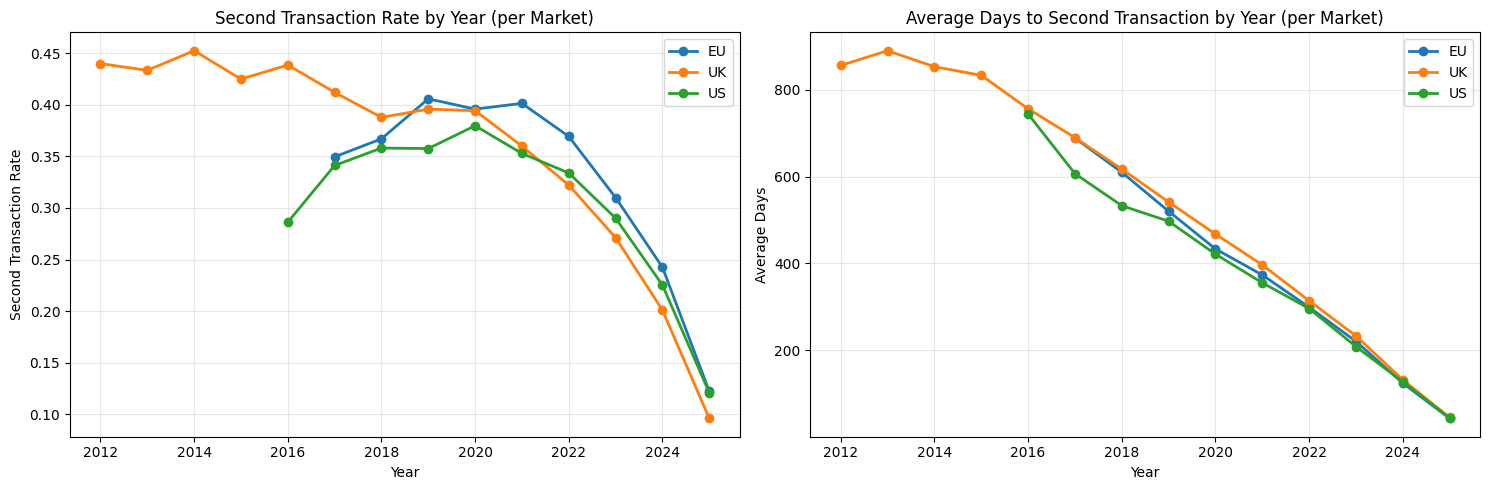

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Two key plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Second transaction rate by year - separate curve per market
yearly_market_stats = df.groupby(['market', df['first_txn_date'].dt.year]).agg({
    'days_between_first_and_second': lambda x: (x > 0).mean()
}).reset_index()

for market in df['market'].unique():
    market_data = yearly_market_stats[yearly_market_stats['market'] == market]
    axes[0].plot(market_data['first_txn_date'], market_data['days_between_first_and_second'], 
                 marker='o', label=market, linewidth=2)

axes[0].set_title('Second Transaction Rate by Year (per Market)')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Second Transaction Rate')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Average days to second transaction by year - separate curve per market
yearly_market_days = df[df['days_between_first_and_second'] > 0].groupby(['market', df['first_txn_date'].dt.year]).agg({
    'days_between_first_and_second': 'mean'
}).reset_index()

for market in df['market'].unique():
    market_data = yearly_market_days[yearly_market_days['market'] == market]
    axes[1].plot(market_data['first_txn_date'], market_data['days_between_first_and_second'], 
                 marker='o', label=market, linewidth=2)

axes[1].set_title('Average Days to Second Transaction by Year (per Market)')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Average Days')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

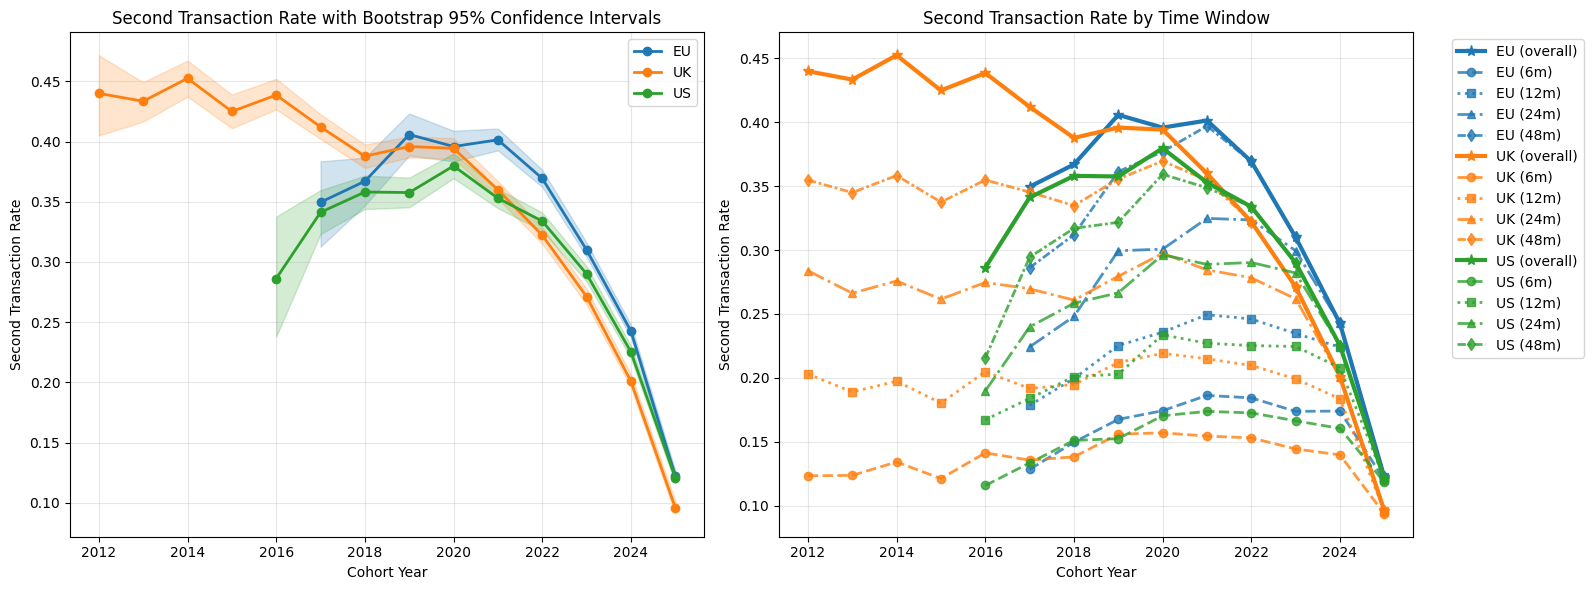

In [19]:
# Advanced plots with uncertainty intervals and additional metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define consistent colors for markets
market_colors = {}
for i, market in enumerate(df['market'].unique()):
    market_colors[market] = f'C{i}'

# 1. Second transaction rate with bootstrap confidence intervals
def bootstrap_ci(data, n_bootstrap=1000, ci=95):
    """Calculate bootstrap confidence intervals for second transaction rate"""
    rates = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        rate = (sample > 0).mean()
        rates.append(rate)
    
    lower = np.percentile(rates, (100-ci)/2)
    upper = np.percentile(rates, 100-(100-ci)/2)
    return lower, upper

for market in df['market'].unique():
    market_data_list = []
    
    for year in sorted(df['first_txn_date'].dt.year.unique()):
        year_market_data = df[(df['market'] == market) & 
                             (df['first_txn_date'].dt.year == year)]['days_between_first_and_second'].values
        
        if len(year_market_data) > 10:  # Need minimum sample size
            rate = (year_market_data > 0).mean()
            lower, upper = bootstrap_ci(year_market_data)
            
            market_data_list.append({
                'year': year,
                'rate': rate,
                'lower': lower,
                'upper': upper
            })
    
    if market_data_list:
        market_df = pd.DataFrame(market_data_list)
        
        axes[0].plot(market_df['year'], market_df['rate'], 
                     marker='o', label=market, linewidth=2, color=market_colors[market])
        axes[0].fill_between(market_df['year'], 
                            market_df['lower'], market_df['upper'], 
                            alpha=0.2, color=market_colors[market])

axes[0].set_title('Second Transaction Rate with Bootstrap 95% Confidence Intervals')
axes[0].set_xlabel('Cohort Year')
axes[0].set_ylabel('Second Transaction Rate')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Second transaction rates by time window (including no time limit)
quick_conversion = df.groupby(['market', df['first_txn_date'].dt.year]).agg({
    'days_between_first_and_second': [
        lambda x: (x > 0).mean(),                 # no time limit (overall rate)
        lambda x: ((x > 0) & (x <= 180)).mean(),  # 6 months
        lambda x: ((x > 0) & (x <= 365)).mean(),  # 12 months
        lambda x: ((x > 0) & (x <= 730)).mean(),  # 24 months
        lambda x: ((x > 0) & (x <= 1460)).mean()  # 48 months (4 years)
    ]
}).reset_index()

quick_conversion.columns = ['market', 'year', 'overall', 'within_6m', 'within_12m', 'within_24m', 'within_48m']

for market in df['market'].unique():
    market_data = quick_conversion[quick_conversion['market'] == market]
    if len(market_data) > 0:
        color = market_colors[market]
        
        axes[1].plot(market_data['year'], market_data['overall'], 
                     marker='*', label=f'{market} (overall)', linewidth=3, 
                     linestyle='-', color=color, markersize=8)
        axes[1].plot(market_data['year'], market_data['within_6m'], 
                     marker='o', label=f'{market} (6m)', linewidth=2, 
                     linestyle='--', color=color, alpha=0.8)
        axes[1].plot(market_data['year'], market_data['within_12m'], 
                     marker='s', label=f'{market} (12m)', linewidth=2, 
                     linestyle=':', color=color, alpha=0.8)
        axes[1].plot(market_data['year'], market_data['within_24m'], 
                     marker='^', label=f'{market} (24m)', linewidth=2, 
                     linestyle='-.', color=color, alpha=0.8)
        axes[1].plot(market_data['year'], market_data['within_48m'], 
                     marker='d', label=f'{market} (48m)', linewidth=2, 
                     linestyle=(0, (3, 1, 1, 1)), color=color, alpha=0.8)

axes[1].set_title('Second Transaction Rate by Time Window')
axes[1].set_xlabel('Cohort Year')
axes[1].set_ylabel('Second Transaction Rate')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

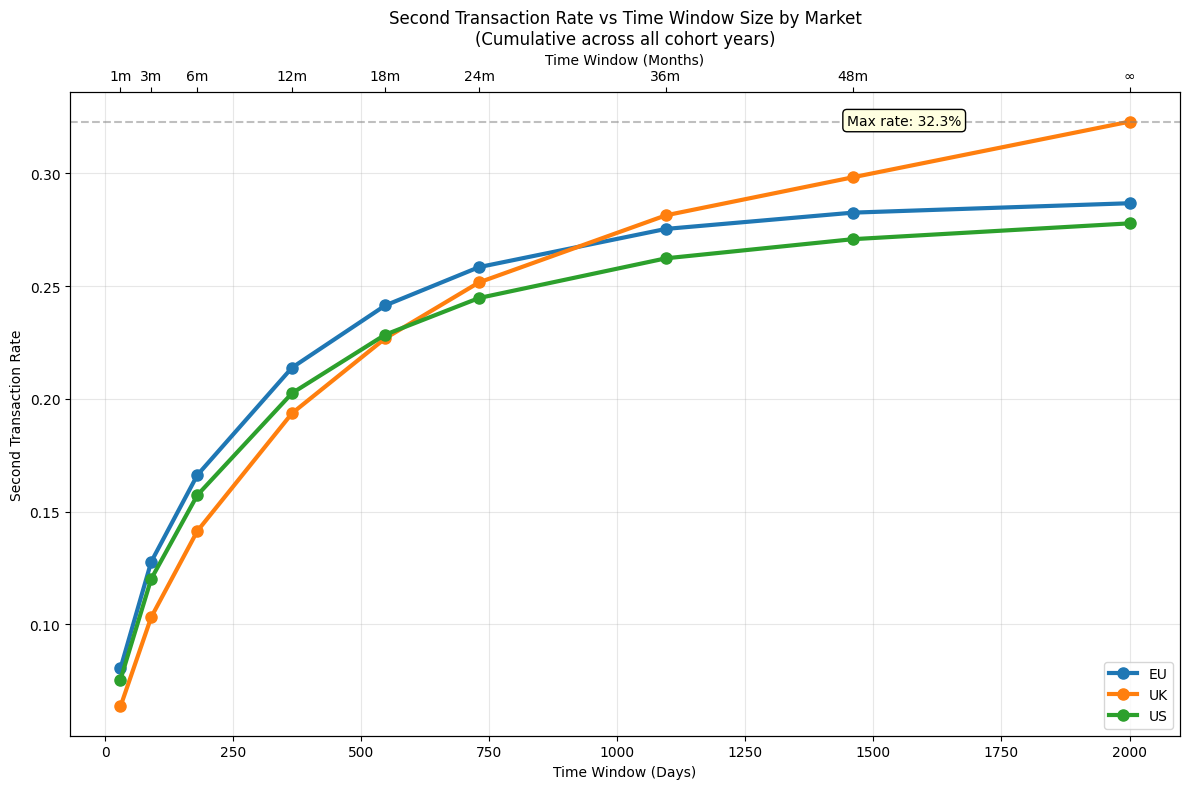

TRANSACTION RATE BY WINDOW SIZE

EU Market:
    1m: 8.0%
    3m: 12.8%
    6m: 16.6%
   12m: 21.4%
   18m: 24.1%
   24m: 25.8%
   36m: 27.5%
   48m: 28.3%
     ∞: 28.7%
  % of ultimate rate achieved:
    At 6m: 58%
    At 12m: 75%
    At 24m: 90%
    At 48m: 99%

UK Market:
    1m: 6.4%
    3m: 10.3%
    6m: 14.1%
   12m: 19.4%
   18m: 22.7%
   24m: 25.2%
   36m: 28.1%
   48m: 29.8%
     ∞: 32.3%
  % of ultimate rate achieved:
    At 6m: 44%
    At 12m: 60%
    At 24m: 78%
    At 48m: 92%

US Market:
    1m: 7.5%
    3m: 12.0%
    6m: 15.7%
   12m: 20.3%
   18m: 22.8%
   24m: 24.5%
   36m: 26.2%
   48m: 27.1%
     ∞: 27.8%
  % of ultimate rate achieved:
    At 6m: 57%
    At 12m: 73%
    At 24m: 88%
    At 48m: 97%


In [20]:
# Transaction rate vs window size analysis
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Define time windows in days and months for labeling
time_windows = [30, 90, 180, 365, 547, 730, 1095, 1460, float('inf')]  # 1m, 3m, 6m, 12m, 18m, 24m, 36m, 48m, ∞
window_labels = ['1m', '3m', '6m', '12m', '18m', '24m', '36m', '48m', '∞']

# Calculate transaction rates for each window size across all years (aggregate)
window_analysis = {}

for market in df['market'].unique():
    market_data = df[df['market'] == market]['days_between_first_and_second']
    rates = []
    
    for window in time_windows:
        if window == float('inf'):
            # For infinite window, just count all customers with second transactions
            rate = (market_data > 0).mean()
        else:
            rate = ((market_data > 0) & (market_data <= window)).mean()
        rates.append(rate)
    
    window_analysis[market] = rates

# For plotting, replace inf with a large number for visualization
plot_windows = [w if w != float('inf') else 2000 for w in time_windows]

# Plot lines for each market
for i, market in enumerate(df['market'].unique()):
    color = f'C{i}'
    ax.plot(plot_windows, window_analysis[market], 
            marker='o', label=market, linewidth=3, markersize=8, color=color)

# Customize the plot
ax.set_xlabel('Time Window (Days)')
ax.set_ylabel('Second Transaction Rate')
ax.set_title('Second Transaction Rate vs Time Window Size by Market\n(Cumulative across all cohort years)')
ax.legend()
ax.grid(True, alpha=0.3)

# Add secondary x-axis with month labels
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(plot_windows)
ax2.set_xticklabels(window_labels)
ax2.set_xlabel('Time Window (Months)')

# Add annotations for key insights
max_overall_rate = max([max(rates) for rates in window_analysis.values()])
ax.axhline(y=max_overall_rate, color='gray', linestyle='--', alpha=0.5)
ax.text(0.7, 0.95, f'Max rate: {max_overall_rate:.1%}', transform=ax.transAxes, 
        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"))

plt.tight_layout()
plt.show()

# Print summary statistics
print("TRANSACTION RATE BY WINDOW SIZE")
print("="*50)
for market in df['market'].unique():
    rates = window_analysis[market]
    print(f"\n{market.upper()} Market:")
    for i, (label, rate) in enumerate(zip(window_labels, rates)):
        print(f"  {label:>4}: {rate:.1%}")
    
    # Calculate how much of final rate is achieved at each milestone
    final_rate = rates[-1]  # The infinite window rate
    if final_rate > 0:
        print(f"  % of ultimate rate achieved:")
        milestones = [2, 3, 5, 7]  # 6m, 12m, 24m, 48m positions
        milestone_labels = ['6m', '12m', '24m', '48m']
        for milestone, label in zip(milestones, milestone_labels):
            if milestone < len(rates) - 1:  # Exclude the infinity point
                pct_achieved = rates[milestone] / final_rate
                print(f"    At {label}: {pct_achieved:.0%}")

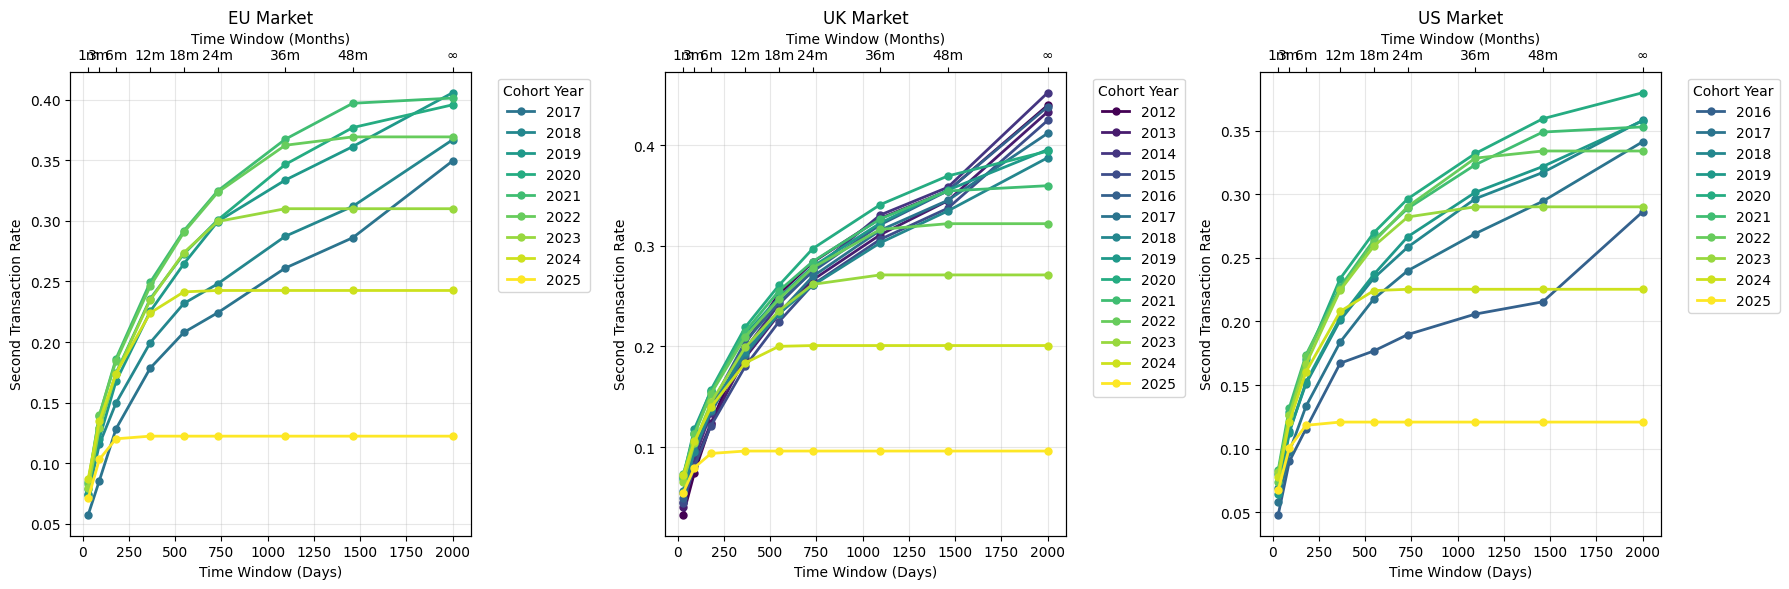

ULTIMATE SECOND TRANSACTION RATES BY COHORT YEAR

EU MARKET:
--------------------
  2017: 35.0% ultimate | 12.8% @6m | 17.8% @12m | n=678
  2018: 36.7% ultimate | 15.0% @6m | 19.9% @12m | n=2,346
  2019: 40.6% ultimate | 16.8% @6m | 22.5% @12m | n=2,925
  2020: 39.6% ultimate | 17.4% @6m | 23.6% @12m | n=5,583
  2021: 40.1% ultimate | 18.6% @6m | 24.9% @12m | n=11,856
  2022: 36.9% ultimate | 18.4% @6m | 24.6% @12m | n=16,475
  2023: 31.0% ultimate | 17.4% @6m | 23.5% @12m | n=23,041
  2024: 24.3% ultimate | 17.4% @6m | 22.4% @12m | n=27,144
  2025: 12.2% ultimate | 12.0% @6m | 12.2% @12m | n=19,714

  Trend (2017-2025): -65.0% change in ultimate rate

UK MARKET:
--------------------
  2012: 44.0% ultimate | 12.3% @6m | 20.3% @12m | n=916
  2013: 43.3% ultimate | 12.4% @6m | 18.9% @12m | n=3,493
  2014: 45.2% ultimate | 13.4% @6m | 19.7% @12m | n=4,144
  2015: 42.5% ultimate | 12.1% @6m | 18.0% @12m | n=4,622
  2016: 43.9% ultimate | 14.1% @6m | 20.5% @12m | n=5,698
  2017: 41.2% ultim

In [22]:
# Transaction rate vs window size by cohort year (separate lines per cohort)
fig, axes = plt.subplots(1, len(df['market'].unique()), figsize=(18, 6))
if len(df['market'].unique()) == 1:
    axes = [axes]

# Define time windows in days and months for labeling
time_windows = [30, 90, 180, 365, 547, 730, 1095, 1460, float('inf')]
window_labels = ['1m', '3m', '6m', '12m', '18m', '24m', '36m', '48m', '∞']

# Select cohort years to analyze (with sufficient data)
cohort_years = sorted([year for year in df['cohort_year'].unique()])

# Define colors for cohort years
import matplotlib.cm as cm
colors = cm.viridis(np.linspace(0, 1, len(cohort_years)))

# Create subplot for each market
for market_idx, market in enumerate(df['market'].unique()):
    ax = axes[market_idx] if len(df['market'].unique()) > 1 else axes[0]
    
    # Plot line for each cohort year
    for cohort_idx, cohort_year in enumerate(cohort_years):
        cohort_market_data = df[(df['market'] == market) & 
                               (df['cohort_year'] == cohort_year)]['days_between_first_and_second']
        
        if len(cohort_market_data) > 100:  # Minimum sample size for reliable curves
            rates = []
            
            for window in time_windows:
                if window == float('inf'):
                    rate = (cohort_market_data > 0).mean()
                else:
                    rate = ((cohort_market_data > 0) & (cohort_market_data <= window)).mean()
                rates.append(rate)
            
            # For plotting, replace inf with a large number
            plot_windows = [w if w != float('inf') else 2000 for w in time_windows]
            
            ax.plot(plot_windows, rates, 
                    marker='o', label=f'{cohort_year}', linewidth=2, markersize=5, 
                    color=colors[cohort_idx])
    
    # Customize subplot
    ax.set_xlabel('Time Window (Days)')
    ax.set_ylabel('Second Transaction Rate')
    ax.set_title(f'{market.upper()} Market')
    ax.legend(title='Cohort Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # Add secondary x-axis with month labels
    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(plot_windows)
    ax2.set_xticklabels(window_labels)
    ax2.set_xlabel('Time Window (Months)')

plt.tight_layout()
plt.show()

# Print summary comparison across cohorts
print("ULTIMATE SECOND TRANSACTION RATES BY COHORT YEAR")
print("="*55)

for market in df['market'].unique():
    print(f"\n{market.upper()} MARKET:")
    print("-" * 20)
    
    cohort_stats = []
    for cohort_year in cohort_years:
        cohort_data = df[(df['market'] == market) & (df['cohort_year'] == cohort_year)]
        if len(cohort_data) > 100:
            ultimate_rate = (cohort_data['days_between_first_and_second'] > 0).mean()
            sample_size = len(cohort_data)
            
            # Calculate 6-month and 12-month rates for comparison
            rate_6m = ((cohort_data['days_between_first_and_second'] > 0) & 
                      (cohort_data['days_between_first_and_second'] <= 180)).mean()
            rate_12m = ((cohort_data['days_between_first_and_second'] > 0) & 
                       (cohort_data['days_between_first_and_second'] <= 365)).mean()
            
            cohort_stats.append({
                'year': cohort_year,
                'ultimate': ultimate_rate,
                'rate_6m': rate_6m,
                'rate_12m': rate_12m,
                'sample_size': sample_size
            })
            
            print(f"  {cohort_year}: {ultimate_rate:.1%} ultimate | {rate_6m:.1%} @6m | {rate_12m:.1%} @12m | n={sample_size:,}")
    
    # Calculate trend
    if len(cohort_stats) >= 3:
        first_rate = cohort_stats[0]['ultimate']
        last_rate = cohort_stats[-1]['ultimate']
        trend = (last_rate - first_rate) / first_rate * 100
        print(f"\n  Trend ({cohort_stats[0]['year']}-{cohort_stats[-1]['year']}): {trend:+.1f}% change in ultimate rate")

# Cross-cohort velocity analysis
print(f"\n\nVELOCITY ANALYSIS (% of Ultimate Rate Achieved)")
print("="*55)

for market in df['market'].unique():
    print(f"\n{market.upper()} MARKET:")
    print("-" * 20)
    print("Cohort  | 6-month | 12-month | 24-month")
    print("--------|---------|----------|----------")
    
    for cohort_year in cohort_years:
        cohort_data = df[(df['market'] == market) & (df['cohort_year'] == cohort_year)]
        if len(cohort_data) > 100:
            ultimate_rate = (cohort_data['days_between_first_and_second'] > 0).mean()
            
            if ultimate_rate > 0:
                rate_6m = ((cohort_data['days_between_first_and_second'] > 0) & 
                          (cohort_data['days_between_first_and_second'] <= 180)).mean()
                rate_12m = ((cohort_data['days_between_first_and_second'] > 0) & 
                           (cohort_data['days_between_first_and_second'] <= 365)).mean()
                rate_24m = ((cohort_data['days_between_first_and_second'] > 0) & 
                           (cohort_data['days_between_first_and_second'] <= 730)).mean()
                
                velocity_6m = rate_6m / ultimate_rate * 100
                velocity_12m = rate_12m / ultimate_rate * 100
                velocity_24m = rate_24m / ultimate_rate * 100
                
                print(f"  {cohort_year}  |   {velocity_6m:5.0f}%  |    {velocity_12m:5.0f}%  |    {velocity_24m:5.0f}%")

In [27]:
from scipy.optimize import curve_fit
import numpy as np

# Simple exponential fit for all market/cohort combinations
def exp_model(t, lam, beta): return lam * (1 - np.exp(-beta * t))

results = []
time_windows = [10, 100, 500, 1000, 2000, 5000, 10000]

for market in df['market'].unique():
    for year in df['cohort_year'].unique():
        data = df[(df['market'] == market) & (df['cohort_year'] == year)]['days_between_first_and_second']
        if len(data) > 100:
            rates = [((data > 0) & (data <= t)).mean() for t in time_windows]
            try:
                (lam, beta), _ = curve_fit(exp_model, time_windows, rates, p0=[max(rates), 0.01], bounds=([0,0], [1,1]))
                results.append({'market': market, 'cohort_year': year, 'lambda': lam, 'beta': beta, 'n': len(data)})
            except: pass

rates_df = pd.DataFrame(results)
print(rates_df.groupby('market')[['lambda', 'beta']].mean())

          lambda      beta
market                    
EU      0.323562  0.005902
UK      0.353106  0.004204
US      0.297389  0.005959


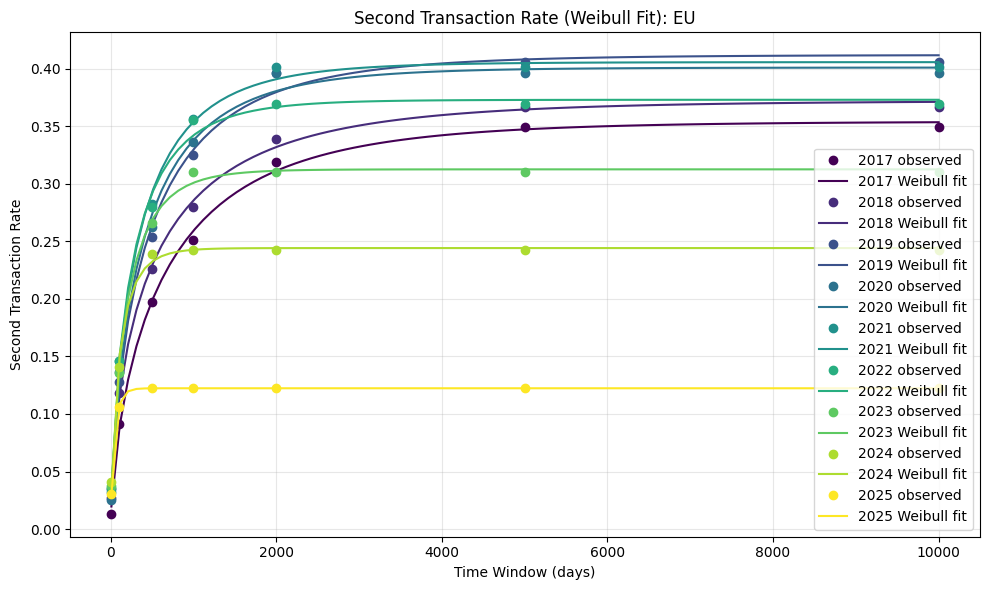

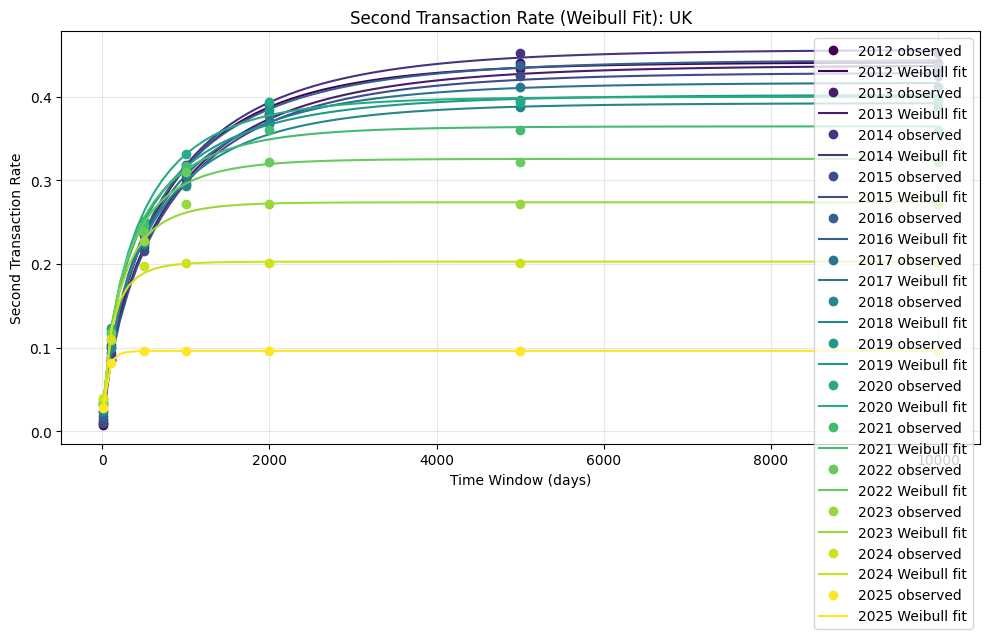

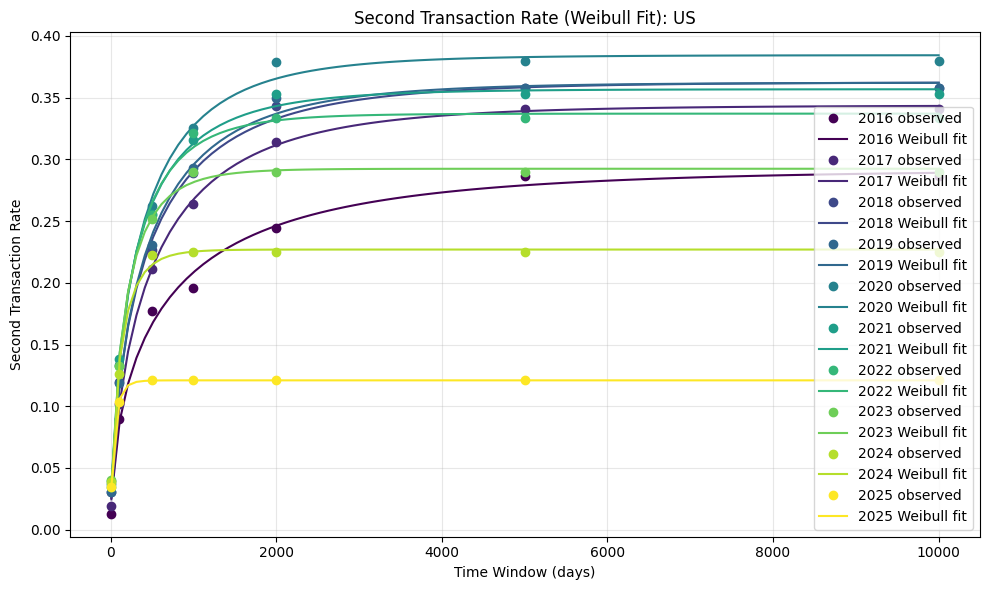

In [28]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

# Weibull CDF model for cumulative rate
# lam: max rate, beta: scale, gamma: shape
# t: time window

def weibull_cdf(t, lam, beta, gamma):
    return lam * (1 - np.exp(-(t / beta) ** gamma))

# Plot per market, lines per cohort year (observed and Weibull fit)
for market in rates_df['market'].unique():
    plt.figure(figsize=(10, 6))
    cohort_years = sorted(rates_df[rates_df['market'] == market]['cohort_year'].unique())
    colors = plt.cm.viridis(np.linspace(0, 1, len(cohort_years)))
    for idx, year in enumerate(cohort_years):
        # Get observed rates
        data = df[(df['market'] == market) & (df['cohort_year'] == year)]['days_between_first_and_second']
        if len(data) > 100:
            observed_rates = [((data > 0) & (data <= t)).mean() for t in time_windows]
            # Fit Weibull CDF
            try:
                popt, _ = curve_fit(
                    weibull_cdf,
                    time_windows,
                    observed_rates,
                    p0=[max(observed_rates), 180, 1],
                    bounds=([0, 1, 0.1], [1, 2000, 5])
                )
                lam, beta, gamma = popt
                t_fit = np.linspace(min(time_windows), max(time_windows), 100)
                fit_curve = weibull_cdf(t_fit, lam, beta, gamma)
                # Plot observed rates
                plt.plot(time_windows, observed_rates, 'o', color=colors[idx], label=f'{year} observed')
                # Plot Weibull fit
                plt.plot(t_fit, fit_curve, '-', color=colors[idx], label=f'{year} Weibull fit')
            except Exception as e:
                plt.plot(time_windows, observed_rates, 'o', color=colors[idx], label=f'{year} observed')
                print(f'Weibull fit failed for {market}, {year}:', e)
    plt.title(f'Second Transaction Rate (Weibull Fit): {market}')
    plt.xlabel('Time Window (days)')
    plt.ylabel('Second Transaction Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

/var/folders/6q/6rsf1x3d1k7fzrsyrjyf8wnc0000gp/T/ipykernel_7859/3388045442.py:7: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


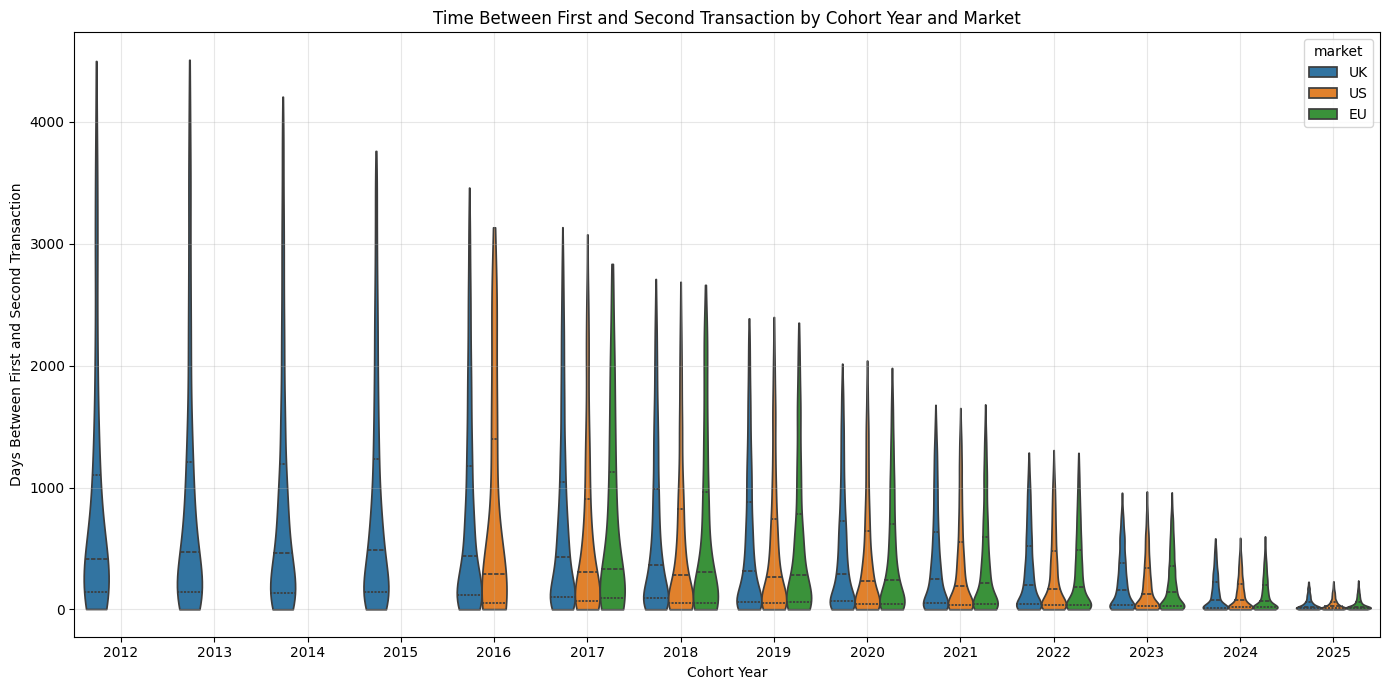

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Violin plot: time between transactions vs cohort date, colored by market
plt.figure(figsize=(14, 7))
subset = df[df['days_between_first_and_second'] > 0]
sns.violinplot(
    x='cohort_year',
    y='days_between_first_and_second',
    hue='market',
    data=subset,
    inner='quartile',
    scale='width',
    cut=0,
    split=False
)
plt.title('Time Between First and Second Transaction by Cohort Year and Market')
plt.xlabel('Cohort Year')
plt.ylabel('Days Between First and Second Transaction')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()